In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/tama/220120_tama.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
# df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-20 13:00:04,#tama954🟣(木曜)
1,2022-01-20 13:00:18,赤江さんの後輩もこの冬いっぱい滝行したよ。 阪神V逸で #tama954
2,2022-01-20 13:00:32,外商の顧客の方！さすがスーさん！ #so954 #tama954
3,2022-01-20 13:00:41,金あったころのスー家は外商の営業が来ていたと。 #so954 #tama954
4,2022-01-20 13:00:45,ウチの実家も羽振りの良い時は西武百貨店の外商入ってました。 #生活は踊る #tama954
...,...,...
1775,2022-01-20 15:31:14,ひとりごと：１年後アメリカが生きてるとは思えないなぁと、、、まぁ地球まるごとだけど。 #t...
1776,2022-01-20 15:31:22,うちの大学は学籍番号を書いて出してたなあ。書く紙を多めに取って代返し放題だったが #tam...
1777,2022-01-20 15:31:29,たまちゃん『Oculusのおかげで我々時計を使わなかったね』ECCカッターのためにもタイマー...
1778,2022-01-20 15:31:40,お疲れさまでしたー #tama954


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-20 13:00:04,木曜
1,2022-01-20 13:00:18,赤江さんの後輩もこの冬いっぱい滝行たよ阪神v逸で
2,2022-01-20 13:00:32,外商の顧客の方さすがスーさん
3,2022-01-20 13:00:41,金あったころのスー家は外商の営業が来ていたと
4,2022-01-20 13:00:45,ウチの実家も羽振りの良い時は西武百貨店の外商入ってまた
...,...,...
1775,2022-01-20 15:31:14,ひとりごと0年後アメリカが生きてるとは思えないなぁとまぁ地球まるごとだけど
1776,2022-01-20 15:31:22,うちの大学は学籍番号を書いて出てたなあ書く紙を多めに取って代返放題だったが
1777,2022-01-20 15:31:29,たまちゃんoculusのおかげで我時計を使わなかったねeccカッターのためにもタイマーは不要...
1778,2022-01-20 15:31:40,お疲れさまでたー


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-20 13:00:04,木曜,[木曜]
1,2022-01-20 13:00:18,赤江さんの後輩もこの冬いっぱい滝行たよ阪神v逸で,"[赤江, さん, 後輩, 冬, いっぱい, 滝行, たよ, 阪神, v, 逸]"
2,2022-01-20 13:00:32,外商の顧客の方さすがスーさん,"[外商, 顧客, 方, さすが, スーさん]"
3,2022-01-20 13:00:41,金あったころのスー家は外商の営業が来ていたと,"[金, あっ, ころ, スー, 家, 外商, 営業, 来, い]"
4,2022-01-20 13:00:45,ウチの実家も羽振りの良い時は西武百貨店の外商入ってまた,"[ウチ, 実家, 羽振り, 良い, 時, 西武百貨店, 外商, 入っ]"
...,...,...,...
1775,2022-01-20 15:31:14,ひとりごと0年後アメリカが生きてるとは思えないなぁとまぁ地球まるごとだけど,"[ひとりご, 0, 年, 後, アメリカ, 生き, てる, 思え, 地球, まるごと]"
1776,2022-01-20 15:31:22,うちの大学は学籍番号を書いて出てたなあ書く紙を多めに取って代返放題だったが,"[うち, 大学, 学籍, 番号, 書い, 出て, 書く, 紙, 多め, 取っ, 代返, 放題]"
1777,2022-01-20 15:31:29,たまちゃんoculusのおかげで我時計を使わなかったねeccカッターのためにもタイマーは不要...,"[たまちゃん, oculus, おかげ, 我, 時計, 使わ, ecc, カッター, ため,..."
1778,2022-01-20 15:31:40,お疲れさまでたー,"[で, ー]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-20 13:00:00,"[木曜, 赤江, さん, 後輩, 冬, いっぱい, 滝行, たよ, 阪神, v, 逸, 外商..."
1,2022-01-20 13:01:00,"[カミさん, お母さん, 実家, 酒屋, 外商, 部, 着物, 買っ, い, おはな, 聞い..."
2,2022-01-20 13:02:00,"[tbs, 時報, ぷっぷっぷっ, ぽーん, ない, ポンコツ, タイマー, 今, い, こ..."
3,2022-01-20 13:03:00,"[生意気, 赤江, 家, 皆さん, 勘違い, 笑, 岡田克也, カモーン, щщ, カモーン..."
4,2022-01-20 13:04:00,"[生意気, w, 悪口, w, quest, 0, 話, いい, スタンドアローン, 楽, ..."
...,...,...
148,2022-01-20 15:28:00,"[あと, ハセン, 氏, やっ, てる, 言っ, またね, 赤江, さん, 銭ゲバ, 無人島..."
149,2022-01-20 15:29:00,"[事, 把握, さ, れ, ちゃう, 代返, でき, 代返, でき, ヒル, バレー, 時計..."
150,2022-01-20 15:30:00,"[で, 来週, ノマタネー, 代返, 出来, 出席, 率, 下がる, もん, 時短, ため,..."
151,2022-01-20 15:31:00,"[ひとりご, 0, 年, 後, アメリカ, 生き, てる, 思え, 地球, まるごと, うち..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
148    None
149    None
150    None
151    None
152    None
Length: 153, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-20 13:00:04,"[1.7854264, -0.72899723, -0.106654584, 0.43237..."
1,2022-01-20 13:00:18,"[-0.26753274, 0.23293833, 0.26743126, -0.20733..."
2,2022-01-20 13:00:32,"[-0.58029306, 0.18702592, -0.17243744, -0.5426..."
3,2022-01-20 13:00:41,"[0.45605707, 0.7110719, 0.009285848, -0.387395..."
4,2022-01-20 13:00:45,"[0.1338361, -0.37168926, -0.29678595, -0.22242..."
...,...,...
1775,2022-01-20 15:31:14,"[-0.61745745, -0.3587803, -0.66391003, 0.59756..."
1776,2022-01-20 15:31:22,"[-0.76247287, 0.34612072, 0.31480494, 0.451530..."
1777,2022-01-20 15:31:29,"[-0.21513294, -0.15583616, -0.89107376, -0.711..."
1778,2022-01-20 15:31:40,"[0.20999895, -1.369871, 0.43777284, 0.16146839..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-20 13:00:00,"[[1.7854264, -0.72899723, -0.106654584, 0.4323..."
1,2022-01-20 13:01:00,"[[0.15770859, -0.16840443, -0.56309575, -0.738..."
2,2022-01-20 13:02:00,"[[-0.77406067, 1.7416323, -0.16711551, -0.9349..."
3,2022-01-20 13:03:00,"[[0.1292224, -0.7821264, -0.3586783, 0.1626464..."
4,2022-01-20 13:04:00,"[[-1.331744, 0.00072063506, -0.421164, -1.1071..."
...,...,...
148,2022-01-20 15:28:00,"[[0.16659579, 0.16286156, 0.014823723, 0.62842..."
149,2022-01-20 15:29:00,"[[0.24776378, 1.0867236, -2.040377, -0.3488404..."
150,2022-01-20 15:30:00,"[[0.6709005, -0.7308377, -0.22742623, 0.079954..."
151,2022-01-20 15:31:00,"[[-0.61745745, -0.3587803, -0.66391003, 0.5975..."


In [13]:
df_vectors.to_csv('vectors.csv', index=False)

In [14]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [15]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-20 13:00:00,0.151758,0.249876,0.409903,0.275598,0.164831
1,2022-01-20 13:01:00,0.319450,0.403125,0.459517,0.396883,0.132287
2,2022-01-20 13:02:00,0.165872,0.246884,0.335858,0.252263,0.134510
3,2022-01-20 13:03:00,0.165907,0.274860,0.393047,0.290815,0.172380
4,2022-01-20 13:04:00,0.223964,0.320487,0.480488,0.372117,0.188492
...,...,...,...,...,...,...
148,2022-01-20 15:28:00,0.205254,0.362750,0.508930,0.365043,0.190422
149,2022-01-20 15:29:00,-0.006207,0.048515,0.099656,0.095706,0.189799
150,2022-01-20 15:30:00,0.313862,0.388336,0.493853,0.405177,0.144213
151,2022-01-20 15:31:00,0.243987,0.310926,0.340874,0.300347,0.081114


In [16]:
df_vectors.to_csv('similarity.csv', index=False)


In [17]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220120_tama/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.151758,0.249876,0.409903,0.275598,0.164831,9
1,2,0.319450,0.403125,0.459517,0.396883,0.132287,12
2,3,0.165872,0.246884,0.335858,0.252263,0.134510,14
3,4,0.165907,0.274860,0.393047,0.290815,0.172380,17
4,5,0.223964,0.320487,0.480488,0.372117,0.188492,15
...,...,...,...,...,...,...,...
148,149,0.205254,0.362750,0.508930,0.365043,0.190422,11
149,150,-0.006207,0.048515,0.099656,0.095706,0.189799,9
150,151,0.313862,0.388336,0.493853,0.405177,0.144213,6
151,152,0.243987,0.310926,0.340874,0.300347,0.081114,4


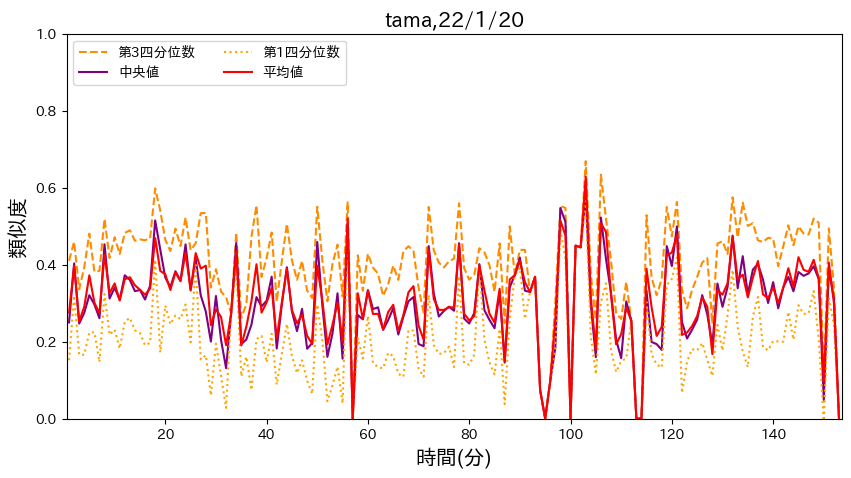

In [18]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/20", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


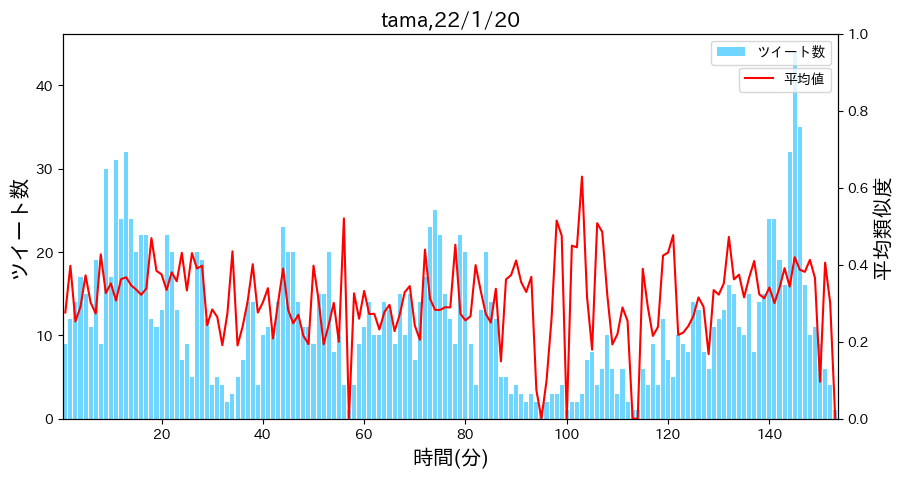

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/20", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


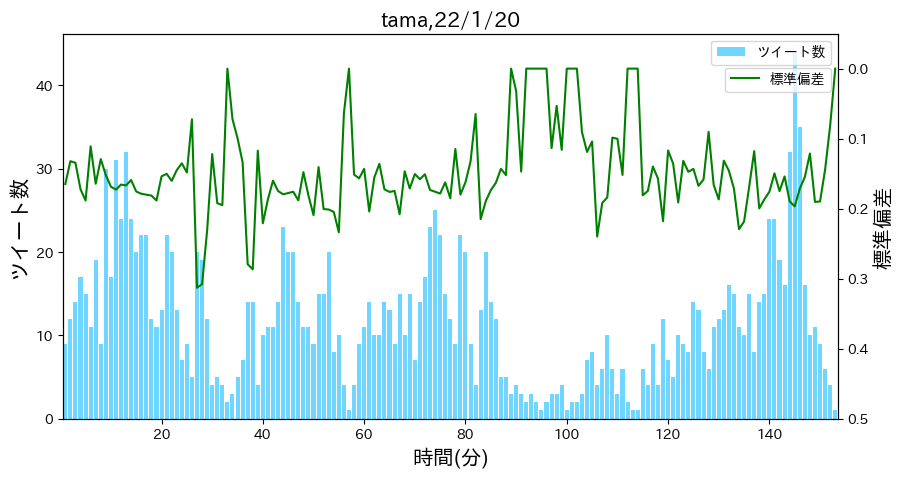

In [20]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/20", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
